*Antras Laboratorinis darbas*

Studentas: **Karolis Miežetis**

Reikalavimai realizuoti:

1. Klasės pasirenkamos savo nuožiūra, tačiau jų turi būti bent 3,
2. Duomenų rinkinys turi būti padalintas į mokymo ir testavimo aibes,
3. Su testavimo duomenų aibe reikia paskaičiuoti šias metrikas: klasifikavimo matrica (angl. confusion matrix), tikslumas, precizija, atkūrimas ir F1.

Pasirinktos klasės:
**Cat, Car, Dog**

In [ ]:
!pip install openimages torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import torchvision
import numpy as np
import random
from torch import nn, optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from openimages.download import download_dataset
from PIL import Image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Naudojamas įrenginys: {device}")

Naudojamas įrenginys: cuda


In [ ]:
classes = ["Cat", "Dog", "Car"]
data_dir = "./openimages"
number_of_samples = 1100

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

print("Parsisiunčiami duomenys...")
download_dataset(data_dir, classes, limit=number_of_samples)


Parsisiunčiami duomenys...


100%|██████████| 1100/1100 [00:28<00:00, 38.47it/s]


{'cat': {'images_dir': './openimages/cat/images'},
 'dog': {'images_dir': './openimages/dog/images'},
 'car': {'images_dir': './openimages/car/images'}}

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class_names = full_dataset.classes
print(f"Klasių pavadinimai: {class_names}")

Klasių pavadinimai: ['car', 'cat', 'dog']


In [ ]:
model = models.resnet50(pretrained=False)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, len(classes))
)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []


epochs = 35
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
    test_acc = correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"→ Test Accuracy: {test_acc:.4f}")
    model.train()

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} — Loss: {train_loss:.4f} — Accuracy: {train_acc:.4f}")

→ Test Accuracy: 0.4833
Epoch 1/35 — Loss: 1.1350 — Accuracy: 0.4466
→ Test Accuracy: 0.5152
Epoch 2/35 — Loss: 1.0743 — Accuracy: 0.4898
→ Test Accuracy: 0.5909
Epoch 3/35 — Loss: 0.9911 — Accuracy: 0.5534
→ Test Accuracy: 0.5303
Epoch 4/35 — Loss: 0.9317 — Accuracy: 0.5727
→ Test Accuracy: 0.6015
Epoch 5/35 — Loss: 0.9117 — Accuracy: 0.5958
→ Test Accuracy: 0.6258
Epoch 6/35 — Loss: 0.9016 — Accuracy: 0.6114
→ Test Accuracy: 0.6045
Epoch 7/35 — Loss: 0.8738 — Accuracy: 0.6254
→ Test Accuracy: 0.6136
Epoch 8/35 — Loss: 0.8339 — Accuracy: 0.6337
→ Test Accuracy: 0.6030
Epoch 9/35 — Loss: 0.8141 — Accuracy: 0.6602
→ Test Accuracy: 0.5758
Epoch 10/35 — Loss: 0.7986 — Accuracy: 0.6587
→ Test Accuracy: 0.5727
Epoch 11/35 — Loss: 0.7893 — Accuracy: 0.6735
→ Test Accuracy: 0.5727
Epoch 12/35 — Loss: 0.7810 — Accuracy: 0.6803
→ Test Accuracy: 0.5848
Epoch 13/35 — Loss: 0.7524 — Accuracy: 0.7015
→ Test Accuracy: 0.5576
Epoch 14/35 — Loss: 0.7415 — Accuracy: 0.7140
→ Test Accuracy: 0.6061
Epoch

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro'))
print("Recall:", recall_score(y_true, y_pred, average='macro'))
print("F1 Score:", f1_score(y_true, y_pred, average='macro'))

Confusion Matrix:
[[186  28  25]
 [ 19 138  58]
 [ 25  84  97]]
Accuracy: 0.6378787878787879
Precision: 0.633194847020934
Recall: 0.6303256431161046
F1 Score: 0.6297720109844512


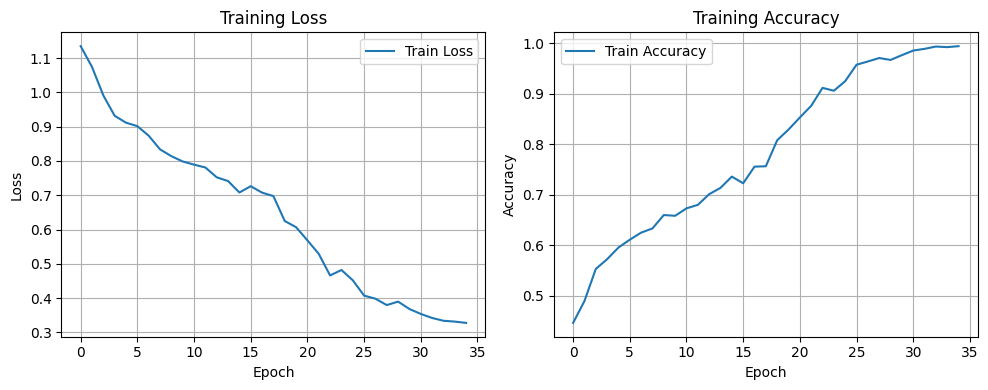

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def show_model_predictions(model, dataset, class_names, device, num_images=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    fig, axs = plt.subplots(1, num_images, figsize=(18, 4))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()

        img_np = image.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        axs[i].imshow(img_np)
        axs[i].set_title(f"Predicted: {class_names[pred]}\nActual: {class_names[label]}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


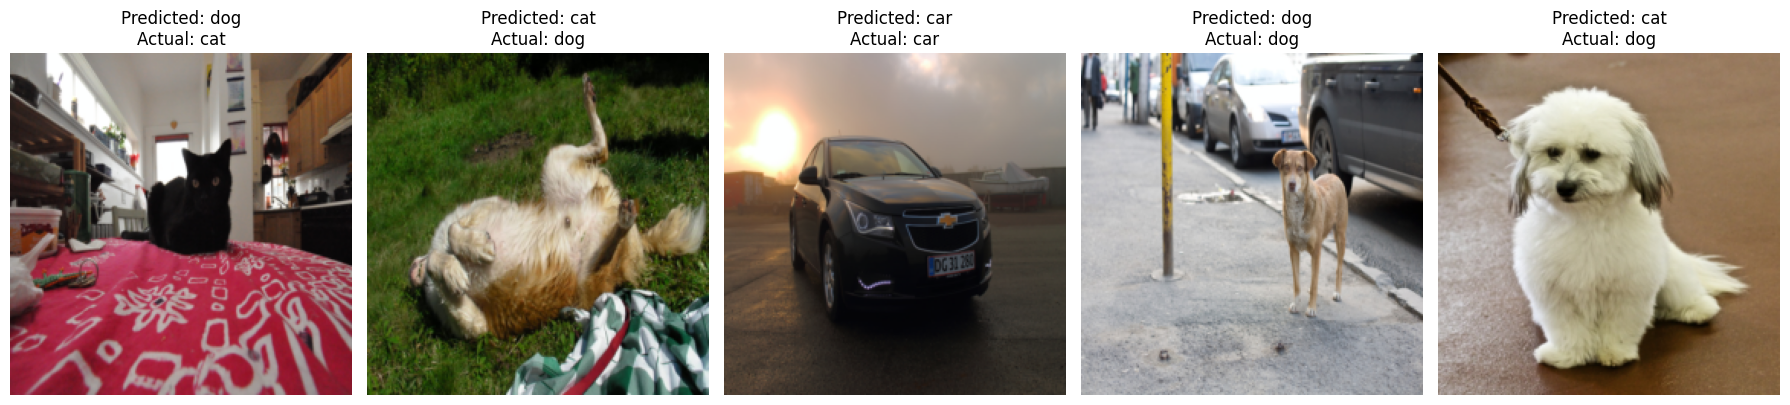

In [ ]:
show_model_predictions(model, test_dataset, class_names, device, num_images=5)